In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from kan import KAN, add_symbolic
from torch.utils.data import TensorDataset, DataLoader

# Load the dataset
data_path = 'RoofTypicalDays_Winter Typical.csv'
data = pd.read_csv(data_path)

# Define input and output columns
input_columns = [ 'Temp', 'Dew', 'Hum', 'Pres', 'Area', 'u-Value (Roof)', 'Heat Capacity']
output_column = 'Winter Typical:Heat Flow'

# Prepare the data
X = data[input_columns].values
y = data[output_column].values

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the data
x_mean = np.mean(X_train, axis=0)
x_std = np.std(X_train, axis=0)
y_mean = np.mean(y_train)
y_std = np.std(y_train)

X_train_scaled = (X_train - x_mean) / x_std
X_test_scaled = (X_test - x_mean) / x_std
y_train_scaled = (y_train - y_mean) / y_std
y_test_scaled = (y_test - y_mean) / y_std

# Convert to tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32).unsqueeze(1)

# Create data loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define the ANN model
class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        self.layer1 = nn.Linear(X_train_tensor.shape[1], 64)
        self.layer2 = nn.Linear(64, 32)
        self.layer3 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = self.layer3(x)
        return x

# Train the ANN model
def train_ann(model, train_loader, criterion, optimizer, epochs=100):
    model.train()
    for epoch in range(epochs):
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# Evaluate the ANN model
def evaluate_ann(model, test_loader, criterion):
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            predictions.append(outputs.numpy())
            actuals.append(targets.numpy())
    predictions = np.concatenate(predictions)
    actuals = np.concatenate(actuals)
    loss = criterion(torch.tensor(predictions), torch.tensor(actuals)).item()
    return predictions, actuals, loss

# Initialize and train the ANN model
ann_model = ANN()
criterion = nn.MSELoss()
optimizer = optim.Adam(ann_model.parameters(), lr=0.001)
train_ann(ann_model, train_loader, criterion, optimizer, epochs=200)

# Evaluate the ANN model
predictions_ann, actuals_ann, loss_ann = evaluate_ann(ann_model, test_loader, criterion)

# Denormalize the predictions and actuals
predictions_ann_denorm = predictions_ann * y_std + y_mean
actuals_ann_denorm = actuals_ann * y_std + y_mean

# Calculate metrics for ANN
mae_ann = mean_absolute_error(actuals_ann_denorm, predictions_ann_denorm)
mse_ann = mean_squared_error(actuals_ann_denorm, predictions_ann_denorm)
r2_ann = r2_score(actuals_ann_denorm, predictions_ann_denorm)

print(f"ANN Performance: MAE: {mae_ann}, MSE: {mse_ann}, R2: {r2_ann}")

# Train the KAN model using the tutorial's approach
kan_model = KAN(width=[len(input_columns), 20, 1], grid=5, k=3, seed=0)

dataset = {
    'train_input': X_train_tensor,
    'train_label': y_train_tensor,
    'test_input': X_test_tensor,
    'test_label': y_test_tensor
}
kan_model.train(dataset, opt="LBFGS", steps=100, lamb=0.001, lamb_entropy=1.0)

# Automatically set activation functions to be symbolic
# lib = ['x', 'x^2', 'x^3', 'x^4', 'exp', 'log', 'sqrt', 'sin', 'abs']
# kan_model.auto_symbolic(lib=lib)
# kan_model.auto_symbolic()
# # Prune the KAN model
# # kan_model.prune()

# # Plot the KAN model
# kan_model.plot()
# kan_model.plot(mask=True)


# # symbolic_formula, x0 = symbolic_formula_with_handling(kan_model, normalizer=[x_mean, x_std], output_normalizer=[[y_mean], [y_std]])
# symbolic_formula = kan_model.symbolic_formula()[0][0]
# symbolic_formula

# print("Discovered Symbolic Formula:")
# print(symbolic_formula)

# Evaluate the KAN model
# kan_model.eval()
with torch.no_grad():
    predictions_kan_scaled = kan_model(X_test_tensor).numpy()

# Denormalize the predictions and actuals for KAN
predictions_kan_denorm = predictions_kan_scaled * y_std + y_mean

# Calculate metrics for KAN
mae_kan = mean_absolute_error(y_test, predictions_kan_denorm)
mse_kan = mean_squared_error(y_test, predictions_kan_denorm)
r2_kan = r2_score(y_test, predictions_kan_denorm)

print(f"KAN Performance: MAE: {mae_kan}, MSE: {mse_kan}, R2: {r2_kan}")

# Plot comparison of actual vs predicted for ANN and KAN
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.plot(actuals_ann_denorm, label='Actual')
plt.plot(predictions_ann_denorm, label='Predicted')
plt.title('ANN Predictions')
plt.xlabel('Sample Index')
plt.ylabel('Output')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(y_test, label='Actual')
plt.plot(predictions_kan_denorm, label='Predicted')
plt.title('KAN Predictions')
plt.xlabel('Sample Index')
plt.ylabel('Output')
plt.legend()

plt.tight_layout()
plt.savefig('Prediction_Comparison.png', dpi=300)
plt.show()


Epoch [10/200], Loss: 0.2056
Epoch [20/200], Loss: 0.1682
Epoch [30/200], Loss: 0.2146
Epoch [40/200], Loss: 0.1132
Epoch [50/200], Loss: 0.0627
Epoch [60/200], Loss: 0.0679
Epoch [70/200], Loss: 0.1038
Epoch [80/200], Loss: 0.2454
Epoch [90/200], Loss: 0.0945
Epoch [100/200], Loss: 0.0800
Epoch [110/200], Loss: 0.0254
Epoch [120/200], Loss: 0.1113
Epoch [130/200], Loss: 0.0866
Epoch [140/200], Loss: 0.1875
Epoch [150/200], Loss: 0.0801
Epoch [160/200], Loss: 0.0703
Epoch [170/200], Loss: 0.1398
Epoch [180/200], Loss: 0.0924
Epoch [190/200], Loss: 0.0677
Epoch [200/200], Loss: 0.1511
ANN Performance: MAE: 651.5320434570312, MSE: 1186681.25, R2: 0.9108456883664195


train loss: 3.84e-01 | test loss: 4.04e-01 | reg: 1.68e+01 :  10%| | 10/100 [01:44<15:37, 10.42s/it]


KeyboardInterrupt: 

Training on task 1
Evaluating on all tasks
Task 1 - MAE: 1129.3111572265625, MSE: 2583285.0, R2: 0.8033410100780884
Task 2 - MAE: 1265.694580078125, MSE: 3291814.5, R2: 0.7494024019354346
Task 3 - MAE: 1271.291015625, MSE: 3240194.25, R2: 0.7533321401482798
Training on task 2
Evaluating on all tasks
Task 1 - MAE: 1018.7623901367188, MSE: 2164498.75, R2: 0.8352221493749618
Task 2 - MAE: 938.2752075195312, MSE: 1919521.625, R2: 0.8538716258286279
Task 3 - MAE: 1087.8602294921875, MSE: 2494440.75, R2: 0.8101044701990815
Training on task 3
Evaluating on all tasks
Task 1 - MAE: 869.25732421875, MSE: 1774778.125, R2: 0.864890599918457
Task 2 - MAE: 978.1575927734375, MSE: 2205680.25, R2: 0.8320870869728634
Task 3 - MAE: 833.7332763671875, MSE: 1651510.5, R2: 0.8742746441894592
Training on task 1


train loss: 3.74e-01 | test loss: 3.74e-01 | reg: 1.70e+01 : 100%|██| 10/10 [00:49<00:00,  4.99s/it]


Evaluating on all tasks
Task 1 - MAE: 929.2148709050903, MSE: 1835269.5051670214, R2: 0.8602855294656149
Task 2 - MAE: 1176.124285372711, MSE: 2832710.833733323, R2: 0.7843528194644904
Task 3 - MAE: 1219.6391642581882, MSE: 2889908.5358352326, R2: 0.7799985016695001
Training on task 2


train loss: 3.45e-01 | test loss: 3.45e-01 | reg: 1.72e+01 : 100%|██| 10/10 [00:53<00:00,  5.37s/it]


Evaluating on all tasks
Task 1 - MAE: 1224.635955549322, MSE: 2868910.763905094, R2: 0.7815970094523417
Task 2 - MAE: 847.7264936003612, MSE: 1563953.776449195, R2: 0.8809401163144343
Task 3 - MAE: 1308.2212162116887, MSE: 3288332.5408657263, R2: 0.7496674801196386
Training on task 3


train loss: 3.31e-01 | test loss: 3.31e-01 | reg: 1.74e+01 : 100%|██| 10/10 [00:51<00:00,  5.19s/it]


Evaluating on all tasks
Task 1 - MAE: 1478.994548436873, MSE: 4032071.4772506547, R2: 0.6930484977738439
Task 2 - MAE: 1782.5425621069617, MSE: 6395716.400344417, R2: 0.5131101301217977
Task 3 - MAE: 807.6810170025166, MSE: 1435565.7070369786, R2: 0.8907139784585814


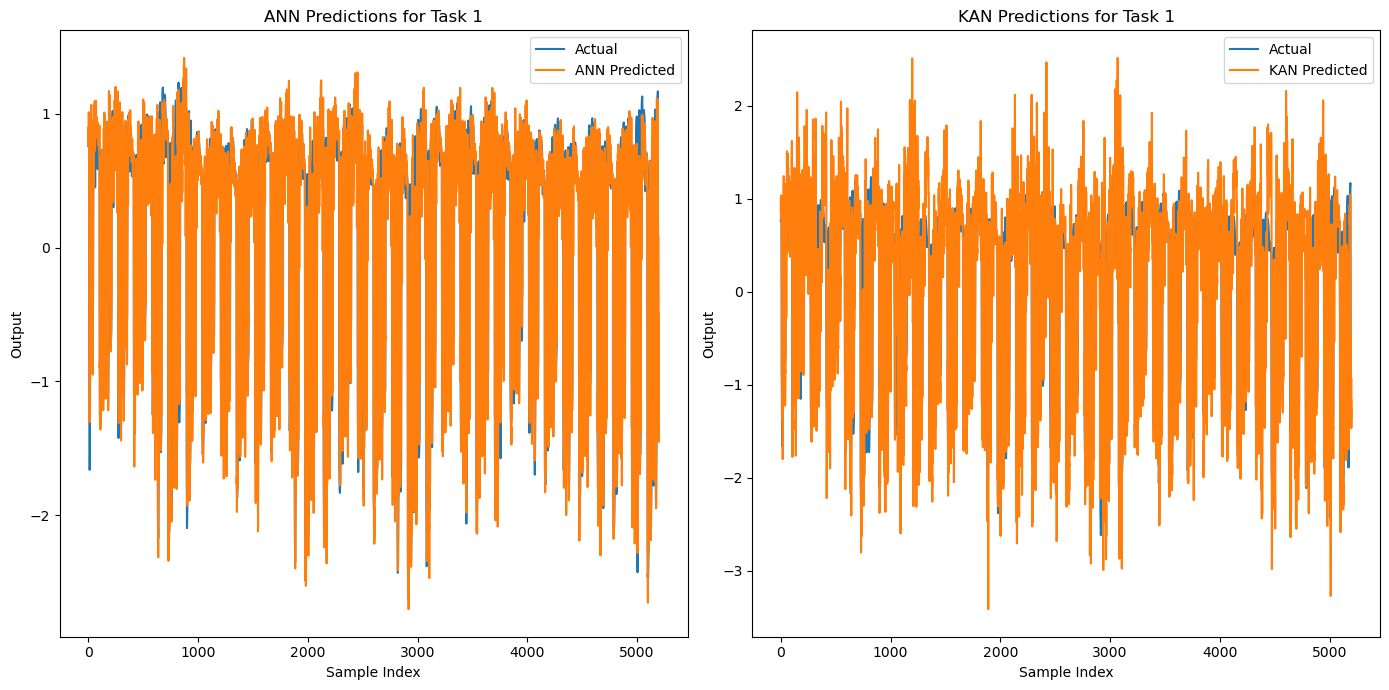

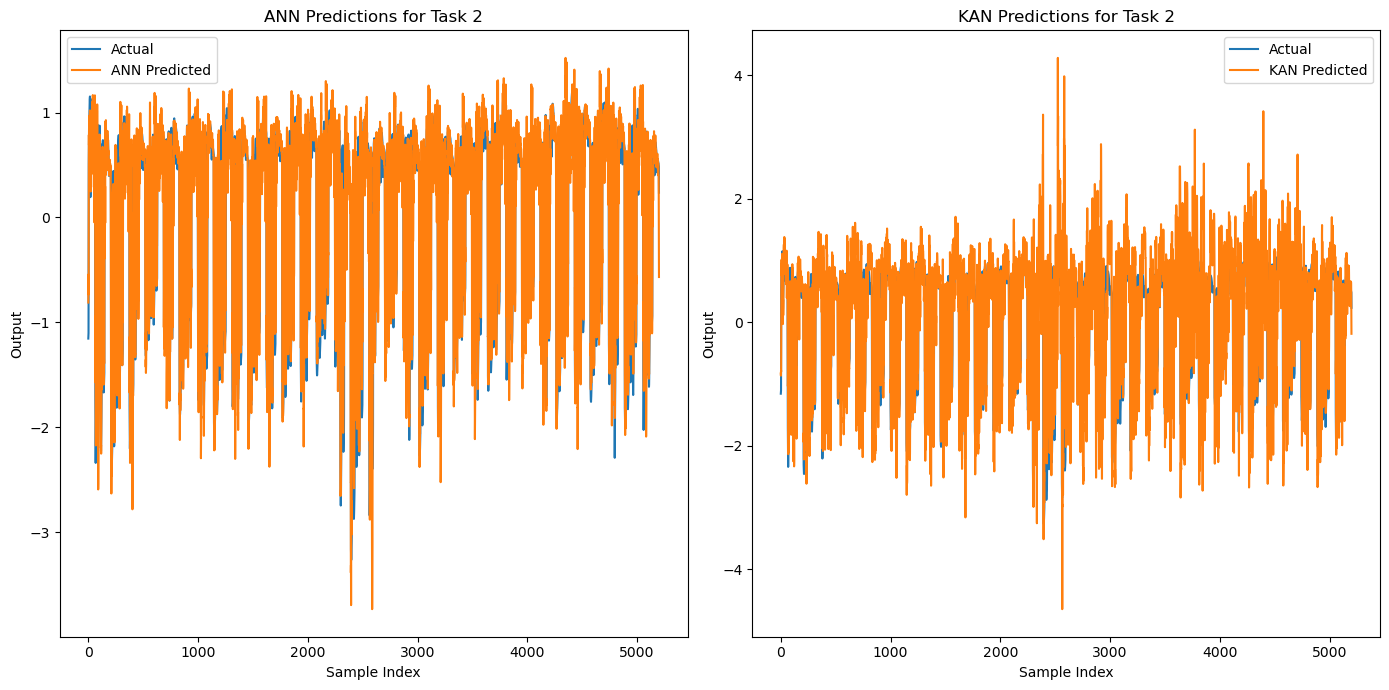

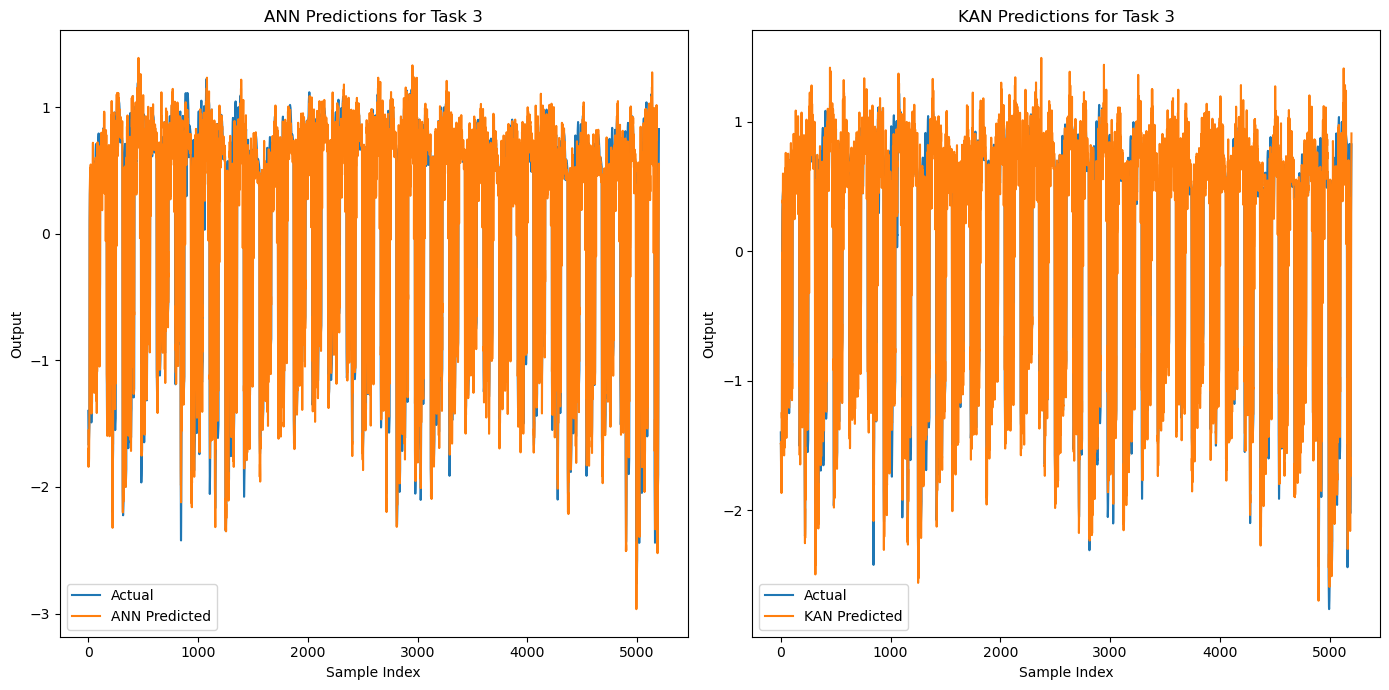

In [3]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from kan import KAN, add_symbolic
from torch.utils.data import TensorDataset, DataLoader

# Load the dataset
data_path = 'RoofTypicalDays_Winter Typical.csv'
data = pd.read_csv(data_path)

# Define input and output columns
input_columns = [ 'Temp', 'Dew', 'Hum', 'Pres', 'Area', 'u-Value (Roof)', 'Heat Capacity']
output_column = 'Winter Typical:Heat Flow'

# Prepare the data
X = data[input_columns].values
y = data[output_column].values

# Split the dataset into multiple tasks
num_tasks = 3
X_splits = np.array_split(X, num_tasks)
y_splits = np.array_split(y, num_tasks)

# Normalize the data
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_splits_scaled = [scaler_X.fit_transform(X_split) for X_split in X_splits]
y_splits_scaled = [scaler_y.fit_transform(y_split.reshape(-1, 1)).flatten() for y_split in y_splits]

# Convert to tensors
X_splits_tensors = [torch.tensor(X_split, dtype=torch.float32) for X_split in X_splits_scaled]
y_splits_tensors = [torch.tensor(y_split, dtype=torch.float32).unsqueeze(1) for y_split in y_splits_scaled]

# Define the ANN model
class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        self.layer1 = nn.Linear(X_splits_tensors[0].shape[1], 64)
        self.layer2 = nn.Linear(64, 32)
        self.layer3 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = self.layer3(x)
        return x

# Train the ANN model
def train_ann(model, train_loader, criterion, optimizer, epochs=100):
    model.train()
    for epoch in range(epochs):
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

# Evaluate the ANN model
def evaluate_ann(model, X_tensors, y_tensors):
    model.eval()
    all_predictions = []
    all_actuals = []
    with torch.no_grad():
        for X, y in zip(X_tensors, y_tensors):
            outputs = model(X)
            all_predictions.append(outputs.numpy())
            all_actuals.append(y.numpy())
    return all_predictions, all_actuals

# Define function to calculate performance metrics
def calculate_metrics(predictions, actuals, y_std, y_mean):
    predictions_denorm = predictions * y_std + y_mean
    actuals_denorm = actuals * y_std + y_mean
    mae = mean_absolute_error(actuals_denorm, predictions_denorm)
    mse = mean_squared_error(actuals_denorm, predictions_denorm)
    r2 = r2_score(actuals_denorm, predictions_denorm)
    return mae, mse, r2

# Initialize and train the ANN model on sequential tasks
ann_model = ANN()
criterion = nn.MSELoss()
optimizer = optim.Adam(ann_model.parameters(), lr=0.001)

for task_id in range(num_tasks):
    print(f"Training on task {task_id + 1}")
    train_dataset = TensorDataset(X_splits_tensors[task_id], y_splits_tensors[task_id])
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    train_ann(ann_model, train_loader, criterion, optimizer, epochs=50)

    print("Evaluating on all tasks")
    all_predictions, all_actuals = evaluate_ann(ann_model, X_splits_tensors, y_splits_tensors)
    for i in range(num_tasks):
        mae, mse, r2 = calculate_metrics(all_predictions[i], all_actuals[i], y_std=scaler_y.scale_[0], y_mean=scaler_y.mean_[0])
        print(f"Task {i + 1} - MAE: {mae}, MSE: {mse}, R2: {r2}")

# Train the KAN model using the tutorial's approach
kan_model = KAN(width=[len(input_columns), 20, 1], grid=5, k=3, seed=0)

for task_id in range(num_tasks):
    print(f"Training on task {task_id + 1}")
    dataset = {
        'train_input': X_splits_tensors[task_id],
        'train_label': y_splits_tensors[task_id],
        'test_input': X_splits_tensors[task_id],
        'test_label': y_splits_tensors[task_id]
    }
    kan_model.train(dataset, opt="LBFGS", steps=10, lamb=0.001, lamb_entropy=1.0)

    print("Evaluating on all tasks")
#     kan_model.eval()
    all_predictions_kan = []
    for X in X_splits_tensors:
        with torch.no_grad():
            predictions_kan_scaled = kan_model(X).numpy()
        all_predictions_kan.append(predictions_kan_scaled)

    for i in range(num_tasks):
        mae, mse, r2 = calculate_metrics(all_predictions_kan[i], y_splits_scaled[i], y_std=scaler_y.scale_[0], y_mean=scaler_y.mean_[0])
        print(f"Task {i + 1} - MAE: {mae}, MSE: {mse}, R2: {r2}")

# Plot comparison of actual vs predicted for ANN and KAN
for task_id in range(num_tasks):
    plt.figure(figsize=(14, 7))
    plt.subplot(1, 2, 1)
    plt.plot(y_splits_scaled[task_id], label='Actual')
    plt.plot(all_predictions[task_id], label='ANN Predicted')
    plt.title(f'ANN Predictions for Task {task_id + 1}')
    plt.xlabel('Sample Index')
    plt.ylabel('Output')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(y_splits_scaled[task_id], label='Actual')
    plt.plot(all_predictions_kan[task_id], label='KAN Predicted')
    plt.title(f'KAN Predictions for Task {task_id + 1}')
    plt.xlabel('Sample Index')
    plt.ylabel('Output')
    plt.legend()

    plt.tight_layout()
    plt.savefig(f'Prediction_Comparison_Task_{task_id + 1}.png', dpi=300)
    plt.show()
